# Community Detection using sectors

## 1. load the required packages

In [1]:
import itertools
import operator
from pylab import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
import networkx.algorithms.community as nxcom
from node2vec import Node2Vec

C:\Users\Danish\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_excel('../data/all_submission_files2.xlsx')
data=df[df["report_end_date"].dt.year==2020]
info = pd.read_excel('../data/investees_info.xlsx')
info = info.set_index('ticker')

In [3]:
test = df.join(info, on="ticker")
test.shape

(46772, 143)

In [4]:
# Find all the possible CIK combinations (sorted) of length 2
all_cik_pairs = list(itertools.combinations(test['cik'].unique(), 2))

In [23]:
def score_of_shared_sectors(L1,L2):
    # Calculates a score for 2 investment funds depending on the overlapping sectors. First the amount of overlapping sectors
    # are calculated. Then the amount of overlapping sectors is normalised by dividing this by the average amount of both  
    # sectors
    L1 = L1.dropna()
    L1n = len(L1)
    L2 = L2.dropna()
    L2n = len(L2)
    shared_sec = 0
    for sector in L1:
        if sector in L2.values:
            loc = L2[L2 == sector].index[0]
            L2 = L2.drop(index=loc)
            shared_sec = shared_sec + 1
    if(L1n+L2n == 0):
        return 0
    else:
        return shared_sec*2/(L1n+L2n)


In [21]:
# create a list of every cik pair with their weight, which is calculated by the function score_of_shared_sectors
nodes_and_edges = []
for cik_pair in all_cik_pairs:
    df1 = test[test['cik']==cik_pair[0]]
    df2 = test[test['cik']==cik_pair[1]]
    score = score_of_shared_sectors(df1["sector"], df2["sector"])
    nodes_and_edges.append([cik_pair, score])

In [7]:
# Build a network of all CIK's.
# Add an edge between each CIK that invests in overlapping cusips, add weight +1 for each overlapping cusip
G=nx.Graph()
for (cik1, cik2), nr_of_shared_sectors in nodes_and_edges:
    if nr_of_shared_sectors == 0:
        pass
        # Don't add the nodes that are not connected, makes the graph impossible to understand
        # G.add_node(cik1)
        # G.add_node(cik2)
    elif nr_of_shared_sectors > 0.85:
        # Take a mimimum amount of shared cusips for visibility
        G.add_edge(cik1,cik2,weight=nr_of_shared_sectors)

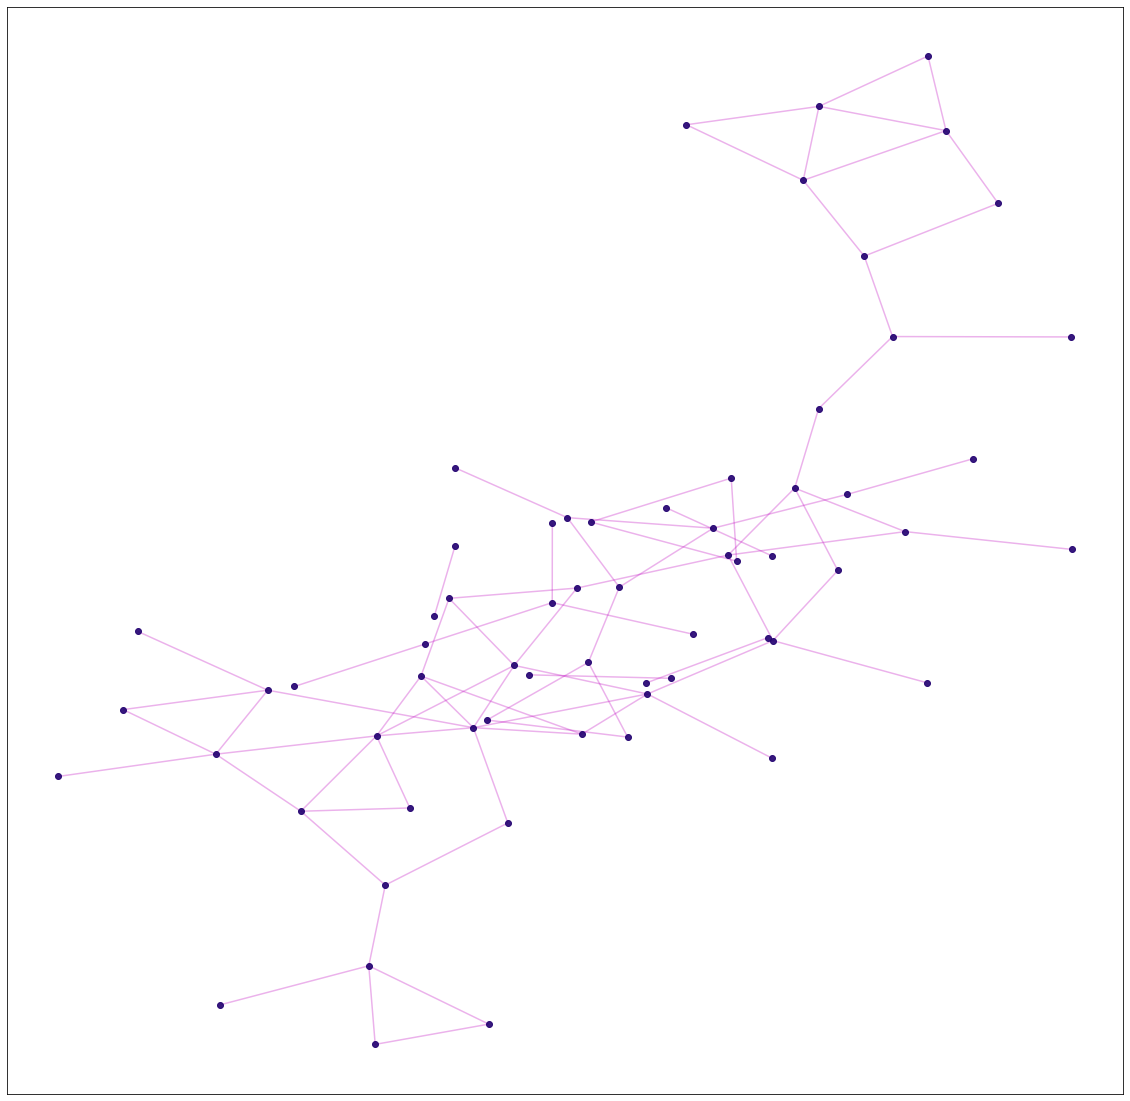

In [8]:
G.edges(data=True)
node_size =  None
edge_width = [w for _,w in nodes_and_edges]
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20,20))
# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, width=None, edge_color="m")
nx.draw_networkx_nodes(G, pos, node_size=None, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
# _ = nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)

In [9]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The group of investment funds has {len(communities)} communities.")
print(communities)

The group of investment funds has 12 communities.
[frozenset({1713697, 1773030, 1777127, 1078246, 1425165, 1695345, 1727605, 1600085, 1508120, 1540569}), frozenset({1729254, 1086763, 1323119, 750641, 1456114, 1434165, 314965, 1475896, 921531}), frozenset({1559077, 1110443, 1845003, 1549042, 1420473, 1740316, 1751581, 1580830}), frozenset({1276673, 1589282, 1733510, 1844393, 1083340, 1055544, 1386364, 1790525}), frozenset({1628896, 1697856, 819535, 1260468, 1717658, 1681372, 1744317}), frozenset({1009254, 1626379, 1387723, 883790, 1034642, 1757043}), frozenset({1727917, 1716539, 1793367, 1766907, 1745885}), frozenset({1661568, 805867, 1570251}), frozenset({1830008, 1846995}), frozenset({1364615, 1344551}), frozenset({1476179, 1081198}), frozenset({1749744, 1566601})]


In [10]:
# Helper functions to plot the graph with community labels
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [11]:
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

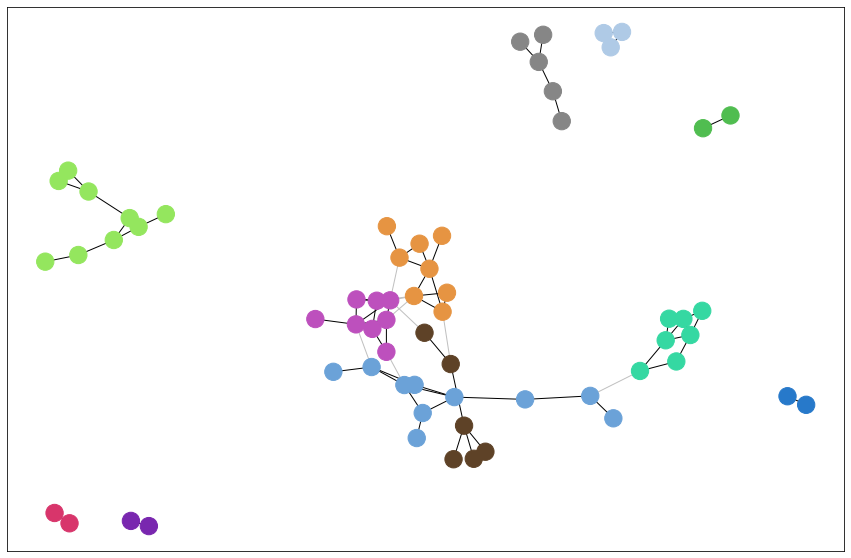

In [12]:
comm_pos = nx.spring_layout(G)

plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    G,
    pos=comm_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver",
    with_labels=False)
# Draw nodes and internal edges
nx.draw_networkx(
    G,
    pos=comm_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color,
    with_labels=False)

# Conclusion

In [18]:
cik1=test[test['cik']==1476179] # investment fund: Firsthand Capital Management, Inc. 
cik2=test[test['cik']==1081198] # investment fund: Cypress Funds Llc

We can use this analysis to find investment funds that are have a similar investment strategy in terms of the sector of the security. As an example, we found 2 investment funds that form a community: "Firsthand Capital Management, Inc." and "Cypress Funds Llc". When we take a closer look at the sectors each of these funds invest in, we see that they are very similar.

In [17]:
print(cik1['sector'].value_counts())
print(cik2['sector'].value_counts())

Technology                17
Communication Services     8
Industrials                7
Consumer Cyclical          3
Healthcare                 1
Financial Services         1
Real Estate                1
Name: sector, dtype: int64
Technology                13
Communication Services     7
Industrials                7
Consumer Cyclical          3
Financial Services         2
Basic Materials            1
Energy                     1
Name: sector, dtype: int64
